## 0. Setup & Data Load
Load libraries, set constants (random seed, paths), and read the CSV.


In [31]:
# 0. Setup & Data Load
import os
from pathlib import Path
import numpy as np
import pandas as pd

RANDOM_STATE = 42
DATA_PATH = "data/anxiety.csv"   # change if needed

plots_dir = Path("plots")
plots_dir.mkdir(exist_ok=True)

df = pd.read_csv(DATA_PATH)
df.head()


,Age,Gender,Occupation,Sleep Hours,Physical Activity (hrs/week),Caffeine Intake (mg/day),Alcohol Consumption (drinks/week),Smoking,Family History of Anxiety,Stress Level (1-10),Heart Rate (bpm),Breathing Rate (breaths/min),Sweating Level (1-5),Dizziness,Medication,Therapy Sessions (per month),Recent Major Life Event,Diet Quality (1-10),Anxiety Level (1-10)
0,29,Female,Artist,6.0,2.7,181,10,Yes,No,10,114,14,4,No,Yes,3,Yes,7,5.0
1,46,Other,Nurse,6.2,5.7,200,8,Yes,Yes,1,62,23,2,Yes,No,2,No,8,3.0
2,64,Male,Other,5.0,3.7,117,4,No,Yes,1,91,28,3,No,No,1,Yes,1,1.0
3,20,Female,Scientist,5.8,2.8,360,6,Yes,No,4,86,17,3,No,No,0,No,1,2.0
4,49,Female,Other,8.2,2.3,247,4,Yes,No,1,98,19,4,Yes,Yes,1,No,3,1.0


## 1. Feature Engineering
Add interaction terms and bucketed categories you designed earlier.  
This can reveal non‑linear relationships and make class boundaries easier to learn.


In [32]:
# 1. Feature Engineering
# Interactions / ratios
df['sleep_stress_int']    = df['Sleep Hours'] * df['Stress Level (1-10)']
df['caffeine_per_sleep']  = df['Caffeine Intake (mg/day)'] / df['Sleep Hours']
df['alc_per_activity']    = df['Alcohol Consumption (drinks/week)'] / (df['Physical Activity (hrs/week)'] + 1e-3)
df['therapy_efficiency']  = df['Therapy Sessions (per month)'] / (df['Stress Level (1-10)'] + 1e-3)

# Composite scores
df['unhealthy_score'] = (
    (df['Smoking'] == 'Yes').astype(int)
  + (df['Alcohol Consumption (drinks/week)'] > 7).astype(int)
  + (df['Caffeine Intake (mg/day)'] > 400).astype(int)
)
df['symptom_severity'] = (
    (df['Dizziness'] == 'Yes').astype(int)
  + df['Sweating Level (1-5)']
  + (df['Recent Major Life Event'] != 'None').astype(int)
)
df['diet_activity_int'] = df['Diet Quality (1-10)'] * df['Physical Activity (hrs/week)']

# Buckets
df['age_group']   = pd.cut(df['Age'], bins=[0,25,35,50,100], labels=['<25','25–35','35–50','50+'])
df['sleep_cat']   = pd.cut(df['Sleep Hours'], bins=[0,6,8,24], labels=['Short (<6h)','Normal (6–8h)','Long (>8h)'])
df['activity_cat']= pd.cut(df['Physical Activity (hrs/week)'], bins=[-1,2,5,100], labels=['Low','Moderate','High'])

df.head()


,Age,Gender,Occupation,Sleep Hours,Physical Activity (hrs/week),Caffeine Intake (mg/day),Alcohol Consumption (drinks/week),Smoking,Family History of Anxiety,Stress Level (1-10),...,sleep_stress_int,caffeine_per_sleep,alc_per_activity,therapy_efficiency,unhealthy_score,symptom_severity,diet_activity_int,age_group,sleep_cat,activity_cat
0,29,Female,Artist,6.0,2.7,181,10,Yes,No,10,...,60.0,30.166667,3.702332,0.299970,2,5,18.9,25–35,Short (<6h),Moderate
1,46,Other,Nurse,6.2,5.7,200,8,Yes,Yes,1,...,6.2,32.258065,1.403263,1.998002,2,4,45.6,35–50,Normal (6–8h),High
2,64,Male,Other,5.0,3.7,117,4,No,Yes,1,...,5.0,23.400000,1.080789,0.999001,0,4,3.7,50+,Short (<6h),Moderate
3,20,Female,Scientist,5.8,2.8,360,6,Yes,No,4,...,23.2,62.068966,2.142092,0.000000,1,4,2.8,<25,Short (<6h),Moderate
4,49,Female,Other,8.2,2.3,247,4,Yes,No,1,...,8.2,30.121951,1.738375,0.999001,1,6,6.9,35–50,Long (>8h),Moderate


## 2. Target Binning (Low / Medium / High)
Convert the 1–10 anxiety score into 3 ordered categories to combat sparsity and class imbalance.


In [33]:
# 2. Target Binning
from sklearn.preprocessing import LabelEncoder

BIN_BOUNDS  = [0, 3, 7, 10]            # (0,3] Low, (3,7] Medium, (7,10] High
BIN_LABELS  = ['Low','Medium','High']

df['anxiety_bin'] = pd.cut(df['Anxiety Level (1-10)'],
                           bins=BIN_BOUNDS, labels=BIN_LABELS,
                           include_lowest=True, right=True)

le = LabelEncoder()
y = le.fit_transform(df['anxiety_bin'])  # 0/1/2 mapped to sorted(BIN_LABELS)

# Drop original/derived target cols from features
X = pd.get_dummies(df.drop(['Anxiety Level (1-10)', 'anxiety_bin'], axis=1),
                   drop_first=True).apply(pd.to_numeric)

y[:5], le.classes_


(array([2, 1, 1, 1, 1]), array(['High', 'Low', 'Medium'], dtype=object))

## 3. Train/Test Split
Use a stratified split so each class proportion is maintained in train & test.


In [34]:
# 3. Train/Test Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# Handy integer ids for classes
hi_id = np.where(le.classes_=='High')[0][0]
lo_id = np.where(le.classes_=='Low')[0][0]
me_id = np.where(le.classes_=='Medium')[0][0]

len(X_train), len(X_test)


(8800, 2200)

## 4. Global Benchmark
Compare multiple model variants via 5‑fold CV on **macro‑F1**:

- LR / RF / XGB
- With and without `class_weight='balanced'`
- With SMOTE & BorderlineSMOTE (oversampling)
- **StandardScaler** only in LR pipelines (trees don’t need scaling)

Pick the best by mean macro‑F1.


In [35]:
# 4. Global Benchmark
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, BorderlineSMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

variants = {
    'LR (base)': Pipeline([
        ('scaler', StandardScaler()),
        ('lr', LogisticRegression(multi_class='multinomial', solver='lbfgs',
                                  max_iter=2000, random_state=RANDOM_STATE))
    ]),
    'RF (base)': RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE),
    'XGB (base)': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=RANDOM_STATE),

    'LR (balanced)': Pipeline([
        ('scaler', StandardScaler()),
        ('lr', LogisticRegression(multi_class='multinomial', solver='lbfgs',
                                  class_weight='balanced', max_iter=2000, random_state=RANDOM_STATE))
    ]),
    'RF (balanced)': RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=RANDOM_STATE),

    'LR + SMOTE': ImbPipeline([
        ('smote', SMOTE(random_state=RANDOM_STATE)),
        ('scaler', StandardScaler()),
        ('lr', LogisticRegression(multi_class='multinomial', solver='lbfgs',
                                  max_iter=2000, random_state=RANDOM_STATE))
    ]),
    'RF + SMOTE': ImbPipeline([
        ('smote', SMOTE(random_state=RANDOM_STATE)),
        ('rf', RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE))
    ]),
    'XGB + SMOTE': ImbPipeline([
        ('smote', SMOTE(random_state=RANDOM_STATE)),
        ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=RANDOM_STATE))
    ]),

    'LR + BSMOTE': ImbPipeline([
        ('bsmote', BorderlineSMOTE(random_state=RANDOM_STATE)),
        ('scaler', StandardScaler()),
        ('lr', LogisticRegression(multi_class='multinomial', solver='lbfgs',
                                  max_iter=2000, random_state=RANDOM_STATE))
    ]),
    'RF + BSMOTE': ImbPipeline([
        ('bsmote', BorderlineSMOTE(random_state=RANDOM_STATE)),
        ('rf', RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE))
    ]),
    'XGB + BSMOTE': ImbPipeline([
        ('bsmote', BorderlineSMOTE(random_state=RANDOM_STATE)),
        ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=RANDOM_STATE))
    ])
}

cv_results = {}
for name, model in variants.items():
    scores = cross_val_score(model, X_train, y_train,
                             cv=5, scoring='f1_macro', n_jobs=-1)
    cv_results[name] = (scores.mean(), scores.std())

cv_df = (pd.DataFrame(cv_results, index=['mean','std']).T
         .sort_values('mean', ascending=False))
cv_df


,mean,std
RF (balanced),0.845616,0.007463
RF + SMOTE,0.845177,0.006085
RF + BSMOTE,0.845059,0.005716
RF (base),0.844704,0.005433
LR (base),0.843253,0.008198
LR + SMOTE,0.840373,0.008587
LR + BSMOTE,0.839609,0.009977
LR (balanced),0.836242,0.009739
XGB + SMOTE,0.833341,0.007265
XGB + BSMOTE,0.833042,0.006517


## 5. Test Evaluation
Fit the best variant on the full training set, evaluate on the test set, and plot a confusion matrix.


Best variant: RF (balanced)
Test macro‑F1: 0.852
Test accuracy: 0.800

Classification Report:
               precision    recall  f1-score   support

        High      1.000     0.990     0.995       203
         Low      0.789     0.789     0.789      1040
      Medium      0.770     0.771     0.770       957

    accuracy                          0.800      2200
   macro avg      0.853     0.850     0.852      2200
weighted avg      0.800     0.800     0.800      2200



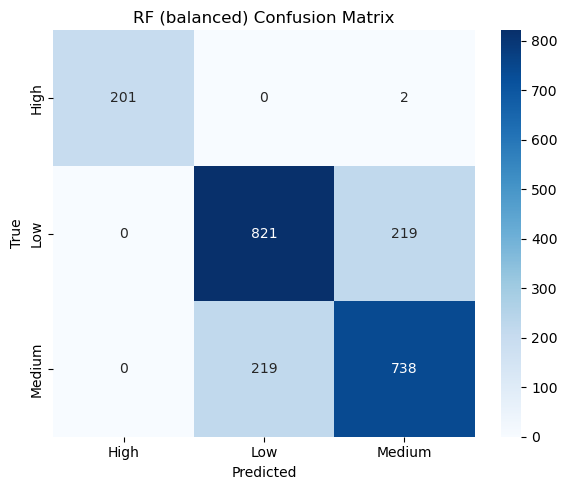

In [36]:
# 5. Test Evaluation
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

best_name = cv_df.index[0]
best_model = variants[best_name].fit(X_train, y_train)

y_pred = best_model.predict(X_test)

print(f"Best variant: {best_name}")
print(f"Test macro‑F1: {f1_score(y_test, y_pred, average='macro'):.3f}")
print(f"Test accuracy: {accuracy_score(y_test, y_pred):.3f}\n")
print("Classification Report:\n",
      classification_report(le.inverse_transform(y_test),
                            le.inverse_transform(y_pred),
                            digits=3))

cm = confusion_matrix(y_test, y_pred, labels=[hi_id, lo_id, me_id])
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['High','Low','Medium'],
            yticklabels=['High','Low','Medium'])
plt.xlabel('Predicted'); plt.ylabel('True')
plt.title(f'{best_name} Confusion Matrix')
plt.tight_layout()
plt.savefig(plots_dir/'cm_best.png')
plt.show()


## 6. Optional: Hierarchical Model
Use the best model twice:
1. Stage 1: High vs Not‑High  
2. Stage 2: Low vs Medium (on remaining samples)

Evaluate whether it actually improves Low/Medium F1. If not, skip it.


Hierarchical -> Macro‑F1(all): 0.854 | Macro‑F1(L+M): 0.784

Classification Report (hierarchical):
               precision    recall  f1-score   support

        High      1.000     0.990     0.995       203
         Low      0.801     0.780     0.790      1040
      Medium      0.766     0.789     0.777       957

    accuracy                          0.803      2200
   macro avg      0.855     0.853     0.854      2200
weighted avg      0.804     0.803     0.803      2200



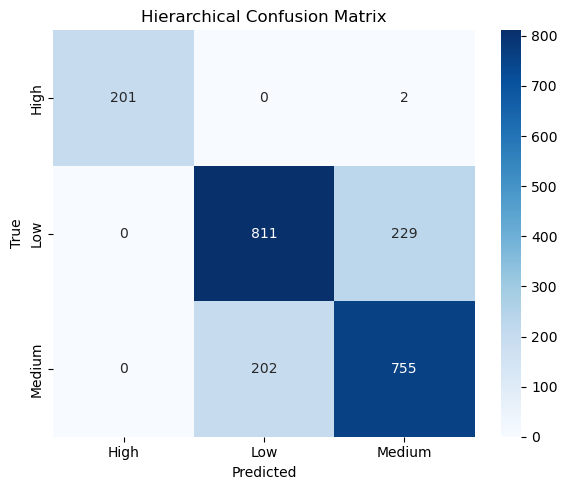

In [37]:
# 6. Optional Hierarchical Model
from sklearn.base import clone

# Stage 1: High vs Rest
y_hi = (y_train == hi_id).astype(int)
clf_hi = clone(best_model)
clf_hi.fit(X_train, y_hi)

# Stage 2: Low vs Medium
mask_lm = (y_train != hi_id)
y_lm = (y_train[mask_lm] == lo_id).astype(int)
clf_lm = clone(best_model)
clf_lm.fit(X_train[mask_lm], y_lm)

# Predict
p_hi = clf_hi.predict(X_test)
pred_final = np.full(len(X_test), me_id)          # default Medium
pred_final[p_hi == 1] = hi_id                     # set High where predicted
idx_rest = np.where(p_hi == 0)[0]
pred_final[idx_rest] = np.where(clf_lm.predict(X_test.iloc[idx_rest])==1, lo_id, me_id)

# Evaluate
macro_all = f1_score(y_test, pred_final, average='macro')
lm_mask   = np.isin(y_test, [lo_id, me_id])
macro_lm  = f1_score(y_test[lm_mask], pred_final[lm_mask], average='macro')

print(f"Hierarchical -> Macro‑F1(all): {macro_all:.3f} | Macro‑F1(L+M): {macro_lm:.3f}\n")
print("Classification Report (hierarchical):\n",
      classification_report(le.inverse_transform(y_test),
                            le.inverse_transform(pred_final),
                            digits=3))

cm_h = confusion_matrix(y_test, pred_final, labels=[hi_id, lo_id, me_id])
plt.figure(figsize=(6,5))
sns.heatmap(cm_h, annot=True, fmt='d', cmap='Blues',
            xticklabels=['High','Low','Medium'],
            yticklabels=['High','Low','Medium'])
plt.xlabel('Predicted'); plt.ylabel('True')
plt.title('Hierarchical Confusion Matrix')
plt.tight_layout()
plt.savefig(plots_dir/'cm_hier.png')
plt.show()
